# <h1><center>EXPLORATORY DATA ANALYSIS</center></h1>
# <h1><center> DataGlacier Assignment</center></h1>

# <h3 align="center">  Marko Andre Talledo Herrera </h3>

# **Libraries & Configuration**

In [1]:

# Basics

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate


# Regression modelling
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import model_selection

# Visualization
import dtale
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors


# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics

# Splitting
from sklearn.model_selection import train_test_split

# Stats & Math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as scy
from scipy.stats import kurtosis
from scipy import stats
from math import sqrt
import random

# Time Series Data Manipulation
from pylab import rcParams
import calendar
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import xlrd

In [2]:
# Showing determined number of columns
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

# Then, setting the style for our charts & plots
sns.set_style('whitegrid')
sns.set_context('notebook')


colors_list = list(colors._colors_full_map.values()) # To adding a little bit of fun to our plots

# **Cab Business Data**

In [3]:
# DATA

# Importing dataset to work with them

path = 'data/in/'
cab_data = pd.read_csv(path + 'Cab_Data.csv')
city_data = pd.read_csv(path + 'City.csv')
customerID = pd.read_csv(path + 'Customer_ID.csv')
transacID = pd.read_csv(path + 'Transaction_ID.csv')


In [4]:
# First we need to get a Dataframe that joins every characteristic of the clients
# Applying merge instance to join tables on Customer ID
df1 = transacID.merge(customerID, on='Customer ID')
df1

# Applying merge instance to join tables on City column
df2 = cab_data.merge(city_data, on='City')
df2

# Merging the last output tables on Transaction ID
# This time NAN's will appear because those trip's data is not available
data = df1.merge(df2, on="Transaction ID", how='outer')
data.head()

,Transaction ID,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Population,Users
0,10000011,29290,Card,Male,28,10813,42377.0,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,"814,885","24,701"
1,10351127,29290,Cash,Male,28,10813,43302.0,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,"814,885","24,701"
2,10412921,29290,Card,Male,28,10813,43427.0,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,"814,885","24,701"
3,10000012,27703,Card,Male,27,9237,42375.0,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,"814,885","24,701"
4,10320494,27703,Card,Male,27,9237,43211.0,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,"814,885","24,701"


### I had merge on Transaction ID because each Customer has many Transactions


# **Exploration**

### With this evidence, we can see that most of the NaN customer data is not useful. Also, the tiny part of NaN data is too short and not significant enough to be imputed.

In [5]:
# That's why it's better to go back
# few steps and merging df1 and df1 with inner joined

data = df1.merge(df2, on="Transaction ID", how='inner')
data.shape

(359392, 14)

## **Data Manipulation & Visualization**

### **Data Types and Customization**

In [6]:
# We have to change the data type to string
data['Customer ID'] = data['Customer ID'].astype('string')
data['Transaction ID'] = data['Transaction ID'].astype('string')

In [7]:
# Income got renamed
data.rename(columns={'Income (USD/Month)': 'Income'}, inplace=True)

In [8]:
# Transforming to date format
data['Date of Travel'] = data['Date of Travel'].apply(
    lambda s: xlrd.xldate.xldate_as_datetime(s, 0))

In [9]:
# Transforming strings to floats
data['Population'] = data['Population'].str.replace(',', '').astype(float)
data['Users'] = data['Users'].str.replace(',', '').astype(float)

### **New Variables and KPIS**

In [10]:
# Profit variable - We need to see what amount of money is gained per service
data['Profit'] = data['Price Charged'] - data['Cost of Trip']
data['Profit']

0          57.3150
1         281.2772
2         194.6480
3          23.6660
4         253.9808
            ...   
359387     47.2656
359388    105.0980
359389     71.2100
359390     21.8600
359391     64.3020
Name: Profit, Length: 359392, dtype: float64

In [11]:
# Unit Cost per KM Travelled
data['cost_per_km'] = data['Cost of Trip'] / data['KM Travelled']
data['cost_per_km']


0         10.30
1         12.12
2         14.04
3         11.70
4         12.84
          ...  
359387    12.84
359388    12.60
359389    12.24
359390    12.60
359391    13.56
Name: cost_per_km, Length: 359392, dtype: float64

In [12]:
# Profit that is gained per KM Travelled
data['profit_per_km'] = data['Profit'] / data['KM Travelled']
data['profit_per_km']

0          1.882266
1         10.739870
2          4.574571
3          0.826904
4          6.981330
            ...    
359387     2.837071
359388     7.660204
359389     3.747895
359390     3.903571
359391     4.834737
Name: profit_per_km, Length: 359392, dtype: float64

### **Outliers Treatment**

In [13]:
# There are many outliers in the 'Price Charged' Variable, it is better to
# drop them in order to clean our data. Interquartile Range method is going to
# be used

Q1 = data['Price Charged'].quantile(0.25)
Q3 = data['Price Charged'].quantile(0.75)

IQR = Q3 - Q1

data = data[(data['Price Charged'] >= (Q1 - 1.5*IQR)) &
            (data['Price Charged'] <= (Q3 + 1.5*IQR))]

In [14]:
# REMOVING OUTLIER
Q1 = data['profit_per_km'].quantile(0.25)
Q3 = data['profit_per_km'].quantile(0.75)

IQR = Q3 - Q1
IQR

data = data[(data['profit_per_km'] >= (Q1 - 1.5*IQR)) &
            (data['profit_per_km'] <= (Q3 + 1.5*IQR))]


# %%

# REMOVING OUTLIERS
Q1 = data['Profit'].quantile(0.25)
Q3 = data['Profit'].quantile(0.75)

IQR = Q3 - Q1
IQR

data = data[(data['Profit'] >= (Q1 - 1.5*IQR)) &
            (data['Profit'] <= (Q3 + 1.5*IQR))]


In [15]:
# REMOVING OUTLIERS PER CITY
for c in data['City'].unique():
    Q1 = data.loc[data['City'] == c, ['Profit']].quantile(0.25)
    Q3 = data.loc[data['City'] == c, ['Profit']].quantile(0.75)
    IQR = Q3 - Q1
    LL = float(Q1 - 1.5*IQR)
    RL = float(Q3 + 1.5*IQR)
    cond1 = (data['City'] == c) & (data['Profit'] >= LL)
    cond2 = (data['City'] == c) & (data['Profit'] <= RL)
    if c == data['City'].unique()[0]:
        outdata = data.loc[cond1 & cond2, :]
    else:
        dummy = data.loc[cond1 & cond2, :]
        outdata = pd.concat([outdata, dummy])
    print(outdata.shape)


(7222, 17)
(11883, 17)
(40408, 17)
(94328, 17)
(100730, 17)
(104363, 17)
(150255, 17)
(156341, 17)
(159175, 17)
(229201, 17)
(232855, 17)
(234819, 17)
(236023, 17)
(238226, 17)
(257920, 17)
(265606, 17)
(273564, 17)
(275383, 17)
(317325, 17)


In [16]:
# REMOVING OUTLIERS PER CITY

for c in outdata['City'].unique():
    Q1 = outdata.loc[outdata['City'] == c, ['profit_per_km']].quantile(0.25)
    Q3 = outdata.loc[outdata['City'] == c, ['profit_per_km']].quantile(0.75)
    IQR = Q3 - Q1
    LL = float(Q1 - 1.5*IQR)
    RL = float(Q3 + 1.5*IQR)
    cond1 = (outdata['City'] == c) & (outdata['profit_per_km'] >= LL)
    cond2 = (outdata['City'] == c) & (outdata['profit_per_km'] <= RL)
    if c == outdata['City'].unique()[0]:
        data_out = outdata.loc[cond1 & cond2, :]
    else:
        dummy = outdata.loc[cond1 & cond2, :]
        data_out = pd.concat([data_out, dummy])
    print(data_out.shape)

(7134, 17)
(11701, 17)
(40007, 17)
(93229, 17)
(99609, 17)
(103217, 17)
(148471, 17)
(154447, 17)
(157233, 17)
(227009, 17)
(230565, 17)
(232511, 17)
(233697, 17)
(235874, 17)
(255296, 17)
(262889, 17)
(270766, 17)
(272552, 17)
(314004, 17)


In [17]:
# %%
cost_medians = data_out.groupby('City')['cost_per_km'].median()


# %%
# STANDARIZING COST PER KM FOR EACH CITY

for cit in data_out['City'].unique():
    data_out.loc[data_out['City'] == cit, ['cost_per_km']] = cost_medians[cit]



# We have decided to choose standard fees because each city has their own cost structure: Taxes, Fees, etc.
# That's why we simplified those fees with the median of its values

# **Modelling**

## **Regression Model**

### **Correlations**

<AxesSubplot:>

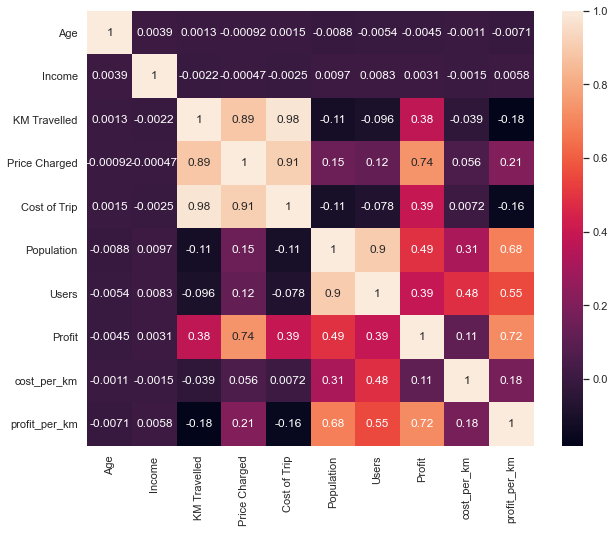

In [32]:
# First, We need to see how the variables are correlated
data_out.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data_out.corr(), annot=True)

# To avoid multicolineality, we must drop variables that are high correlate to other.

In [26]:
# In that case, we select these
regdata = data_out.loc[:, np.isin(data_out.columns, ['Profit', 'Price Charged', 'Users', 'Population',
                                                    'Cost of Trip'], invert=True)]



<AxesSubplot:>

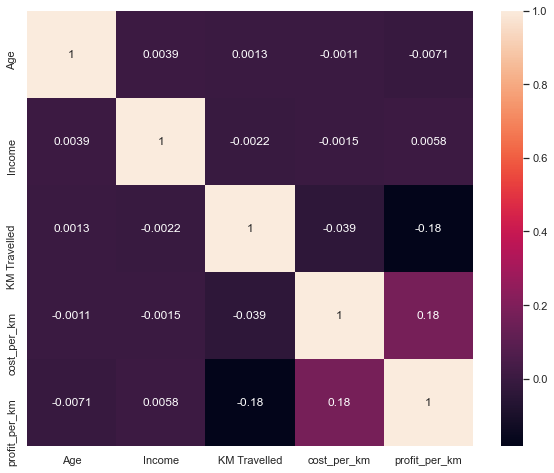

In [33]:
# %%
# Then we plot again
regdata.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(regdata.corr(), annot=True)

In [34]:
regdata.loc[regdata['City'] in ]

,Transaction ID,Customer ID,Payment_Mode,Gender,Age,Income,Date of Travel,Company,City,KM Travelled,cost_per_km,profit_per_km
0,10000011,29290,Card,Male,28,10813,2016-01-08,Pink Cab,ATLANTA GA,30.45,12.84,1.882266
1,10351127,29290,Cash,Male,28,10813,2018-07-21,Yellow Cab,ATLANTA GA,26.19,12.84,10.739870
2,10412921,29290,Card,Male,28,10813,2018-11-23,Yellow Cab,ATLANTA GA,42.55,12.84,4.574571
3,10000012,27703,Card,Male,27,9237,2016-01-06,Pink Cab,ATLANTA GA,28.62,12.84,0.826904
4,10320494,27703,Card,Male,27,9237,2018-04-21,Yellow Cab,ATLANTA GA,36.38,12.84,6.981330
...,...,...,...,...,...,...,...,...,...,...,...,...
352518,10307228,51406,Cash,Female,29,6829,2018-03-03,Yellow Cab,WASHINGTON DC,38.40,13.08,3.740052
352519,10319775,51406,Cash,Female,29,6829,2018-04-13,Yellow Cab,WASHINGTON DC,3.57,13.08,6.455574
352520,10347676,51406,Card,Female,29,6829,2018-07-06,Yellow Cab,WASHINGTON DC,23.46,13.08,-0.249531
352521,10358624,51406,Cash,Female,29,6829,2018-08-02,Yellow Cab,WASHINGTON DC,27.60,13.08,-0.220652
